In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split

import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf

%matplotlib inline

In [19]:
df_train = pd.read_csv('../../data/titanic/train.csv')
df_test = pd.read_csv('../../data/titanic/test.csv')     

df_train[['Name']].head(2)

,Name
0,"Braund, Mr. Owen Harris"
1,"Cumings, Mrs. John Bradley (Florence Briggs Th..."


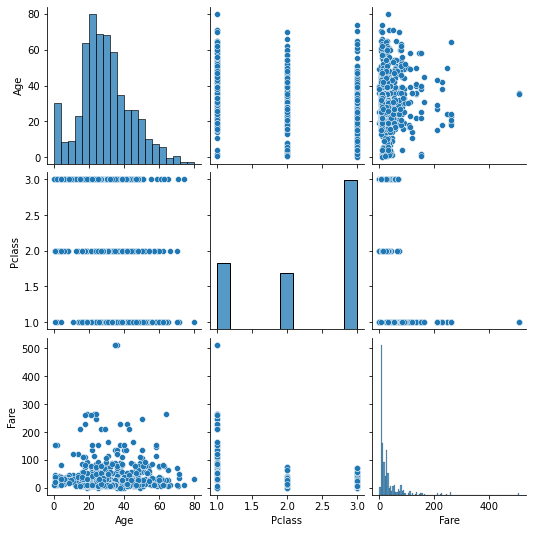

In [20]:
sns.pairplot(df_train[['Age','Sex','Pclass','Fare']])

In [21]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [22]:
df_train.fillna({'Pclass':2, 'Sex':'male', 'Age':29.6,'Fare':32.2}, inplace=True)
df_test.fillna({'Pclass':2, 'Sex':'male', 'Age':29.6,'Fare':32.2},  inplace=True)

df_train[['Mrs']] = df_train[['Name']].applymap(lambda s: 1. if s.find('Mrs.') != -1 else 0.)
df_train[['Miss']] = df_train[['Name']].applymap(lambda s: 1. if s.find('Miss.') != -1 else 0.)

df_test[['Mrs']] = df_test[['Name']].applymap(lambda s: 1. if s.find('Mrs.') != -1 else 0.)
df_test[['Miss']] = df_test[['Name']].applymap(lambda s: 1. if s.find('Miss.') != -1 else 0.)

df_test[['Name', 'Mrs', 'Miss']].head(10)

,Name,Mrs,Miss
0,"Kelly, Mr. James",0.0,0.0
1,"Wilkes, Mrs. James (Ellen Needs)",1.0,0.0
2,"Myles, Mr. Thomas Francis",0.0,0.0
3,"Wirz, Mr. Albert",0.0,0.0
4,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",1.0,0.0
5,"Svensson, Mr. Johan Cervin",0.0,0.0
6,"Connolly, Miss. Kate",0.0,1.0
7,"Caldwell, Mr. Albert Francis",0.0,0.0
8,"Abrahim, Mrs. Joseph (Sophie Halaut Easu)",1.0,0.0
9,"Davies, Mr. John Samuel",0.0,0.0


In [23]:
def create_dataset(df, train=True):
    selected_fields = ['Pclass', 'Sex', 'Age','Fare','Mrs','Miss']
    
    if train:
        target = df[['Survived']].values
        ds = tf.data.Dataset.from_tensor_slices((df[selected_fields].to_dict('list'), 
                                                target)).shuffle(1024).batch(128, drop_remainder=False)  
    else:
        ds = tf.data.Dataset.from_tensor_slices(df[selected_fields].to_dict('list')).batch(1)
      
    return ds    

In [24]:
ds_train = create_dataset(df_train, True)
ds_test = create_dataset(df_test, False)

for x in ds_test.take(1):
    print(x)

{'Pclass': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>, 'Sex': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'male'], dtype=object)>, 'Age': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([34.5], dtype=float32)>, 'Fare': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([7.8292], dtype=float32)>, 'Mrs': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>, 'Miss': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>}


In [55]:
def create_features():
    pclass = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(key='Pclass', vocabulary_list=(1,2,3))
    )
    sex = tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(key='Sex', vocabulary_list=['male', 'female'])
    )
    age = tf.feature_column.numeric_column(key='Age')
    fare = tf.feature_column.numeric_column(key='Fare')
    miss = tf.feature_column.numeric_column(key='Miss')
    mrs = tf.feature_column.numeric_column(key='Mrs')
        
    return [pclass, sex, age, fare, miss, mrs]

def create_feature_layer_inputs():
    """
    мы тут задаем именно типы входных слайсов и их шейпы. Шейпы разные могут быть на входе - 
    что-то может вообще под одним именем заходить но большое - например картинка
    """
    feature_layer_inputs = {}
    feature_layer_inputs["Pclass"] = tf.keras.Input(shape=(), name="Pclass", dtype=tf.int64)
    feature_layer_inputs["Sex"] = tf.keras.Input(shape=(), name="Sex", dtype=tf.string)
    feature_layer_inputs["Age"] = tf.keras.Input(shape=(), name="Age", dtype=tf.float32)
    feature_layer_inputs["Fare"] = tf.keras.Input(shape=(), name="Fare", dtype=tf.float32)
    feature_layer_inputs["Mrs"] = tf.keras.Input(shape=(), name="Mrs", dtype=tf.float32)
    feature_layer_inputs["Miss"] = tf.keras.Input(shape=(), name="Miss", dtype=tf.float32)
    return feature_layer_inputs




In [61]:
features = create_features()
inputs = create_feature_layer_inputs()

model = tf.keras.Sequential([
    tf.keras.layers.DenseFeatures(features, name='nputs'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
model.fit(ds_train, epochs=1, verbose=0)

Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.


In [48]:
preds = model.predict(ds_test)

Consider rewriting this model with the Functional API.


In [49]:
preds[:10]

array([[0.24060026],
       [0.2118457 ],
       [0.15970466],
       [0.26120892],
       [0.31040215],
       [0.36432314],
       [0.25144345],
       [0.38709182],
       [0.33726877],
       [0.403043  ]], dtype=float32)

In [50]:
df_res = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': tf.cast(tf.round(tf.squeeze(preds)), dtype=tf.int32)})
df_res.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [51]:
df_res.to_csv('../../data/titanic/result.csv', index=False)

## Пробую сделать простейшую функциональную модель

    Не ясно почему, но тут нужно задавать словарь имен фич с указанием их шейпов. 
    Хотя вообще яснов принципе

In [77]:
features = create_features()
inputs = create_feature_layer_inputs()

# input_layer - у меня уже есть 
input_layer = tf.keras.layers.DenseFeatures(features, name='inputs')(inputs)
h1 = tf.keras.layers.Dense(128, activation="relu", name="h1")(input_layer)
d1 = tf.keras.layers.Dropout(0.1, name="d1")(h1)
h2 = tf.keras.layers.Dense(64, activation="relu",name="h2")(d1)
d2 = tf.keras.layers.Dropout(0.1, name="d2")(h2)
h3 = tf.keras.layers.Dense(32, activation="relu", name="h3")(d2)
output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(h3)



In [78]:
model = tf.keras.Model(inputs=inputs, outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

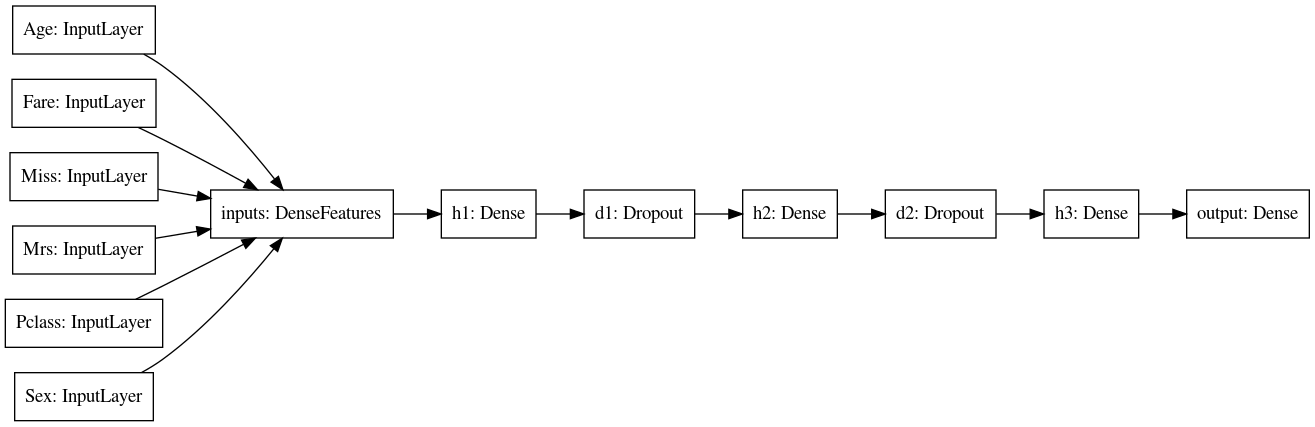

In [79]:
tf.keras.utils.plot_model(model, show_shapes=False, rankdir='LR')

In [88]:
history = model.fit(ds_train, epochs=1000, verbose=0)

<AxesSubplot:>

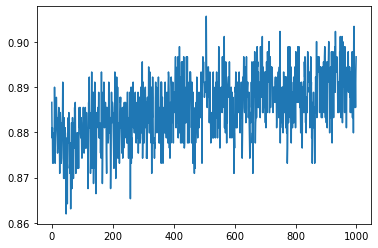

In [90]:
pd.DataFrame(history.history)['accuracy'].plot()

In [91]:
preds = model.predict(ds_test)
preds[:10]

array([[9.5937937e-02],
       [9.9750853e-01],
       [4.3187410e-02],
       [1.5890402e-01],
       [9.9756825e-01],
       [3.8872024e-01],
       [6.5676981e-01],
       [3.3106258e-05],
       [9.9970174e-01],
       [2.6969314e-03]], dtype=float32)

In [92]:
df_res = pd.DataFrame({'PassengerId': df_test['PassengerId'], 'Survived': tf.cast(tf.round(tf.squeeze(preds)), dtype=tf.int32)})
df_res.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [85]:
df_res.to_csv('../../data/titanic/result.csv', index=False)